In [2]:
import os
import requests
from bs4 import BeautifulSoup
from PIL import Image
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

In [3]:
PRODUCT_ID = 'B0BN72FYFG' #'B0101SI6W4'

In [4]:
# Define your custom headers here
headers = {
    'authority': 'www.google.com',
    'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7',
    'accept-language': 'en-US,en;q=0.9',
    'cache-control': 'max-age=0',
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/115.0.0.0 Safari/537.36',
}

In [35]:
def get_images(folder, url, headers):
    
    os.makedirs(folder, exist_ok = True)

    for p_type in ['amazon', 'new', 'used']:

        fn = os.path.join(folder, f'{p_type}.png')
        if os.path.exists(fn):
            print(p_type, '\talready exists')
            continue
        
        img_url = url + f'{p_type}.png'
        try:
            with requests.Session() as s:
                r = s.get(url = img_url, headers=headers)
            r.raise_for_status()

            with open(fn, "wb+") as f:
                f.write(r.content)

        except requests.HTTPError as e:
            print('Error', e)
        
        print(p_type, '\t', r.status_code)

In [6]:
# scrape images
base_folder = f"images/{PRODUCT_ID}"
base_url = f'https://charts.camelcamelcamel.com/us/{PRODUCT_ID}/'
status = get_images(base_folder, base_url, headers)

amazon 	 200
new 	 200
used 	 200


In [19]:
def get_prices(url, headers):

    with requests.Session() as s:
        r = s.get(url = url, headers=headers)

    soup = BeautifulSoup(r.content, 'html')

    prices = {}
    for p_type in ['amazon', 'new', 'used']:

        prices[p_type] = {}
        res = soup.select(f'tr[class*="pt {p_type}"]')

        for val, l in zip(['min', 'max', 'current', 'average'], str(res[0]).split('<td>\n')[1:5]):
            price = l.split('\n')[0][1:]
            if price == '':
                prices[p_type][val] = np.nan
            else:
                prices[p_type][val] = float(price)

        res = soup.findAll('tr', {'class': 'pt used'})

    title = soup.findAll('a', attrs={'class': 'h1la active'})[0]['title'].split('|')[0][:-1]
    return title, prices

In [20]:
# scrape prices
prod_url = f'https://camelcamelcamel.com/product/{PRODUCT_ID}'
title, prices = get_prices(prod_url, headers)

In [22]:
def find_row(data, color):
    
    l = {}
    for idx, row in enumerate(data):
        count = pd.DataFrame(row).value_counts()
        try:
            n_color = count.loc[color]
            l[idx] = n_color
        except KeyError as e:
            pass

    return pd.Series(l).idxmax()

In [23]:
def crop_frame(data, colors):
    top = find_row(data, colors['top']) # row with most of top color
    bottom = find_row(data, colors['bottom']) # row with most of bottom color
    left = find_row(data.transpose(1, 0, 2), (0, 0, 0, 255)) # column with most black
    right = find_row(data[:, left:, :].transpose(1, 0, 2), (255, 255, 255, 255)) # first column with all white to the right of left

    data = data[top+1:bottom, left+2:right, :]
    return data

In [24]:
def find_trace(data, colors):
    trace = {}
    for idx, col in enumerate(data.transpose(1, 0, 2)):
        try:
            mean = np.where(np.all(col == np.array(colors['trace']).reshape(1, -1), axis = -1))[0][[0, -1]].mean()
            trace[idx] = data.shape[0]-mean
        except IndexError as e:
            trace[idx] = np.nan

    trace = pd.Series(trace)
    return trace

In [25]:
def get_price_dates(trace, prices, n_days = 365):

    vals = prices['min'] + (prices['max']-prices['min'])/trace.max()*trace.values
    idcs = [datetime.today() + pd.DateOffset(years = -1) + pd.DateOffset(days = day) for day in (trace.index/trace.index.max()*365)]

    return pd.Series(vals, index = idcs)

In [26]:
colors = {'top': (255, 0, 0, 255), 'bottom': (0, 255, 0, 255), 'trace': (0, 0, 0, 255)}

In [43]:
def check_image(data):
    placeholder = np.array(Image.open(f'images/placeholder.png'))

    try:
        if (data == placeholder).all():
            print(f'Skipping {PRODUCT_ID} {p_type}; we scraped a placeholder image')
            return False
        else:
            return True
    except ValueError as e:
        return True

Skipping B0BN72FYFG amazon; we scraped a placeholder image


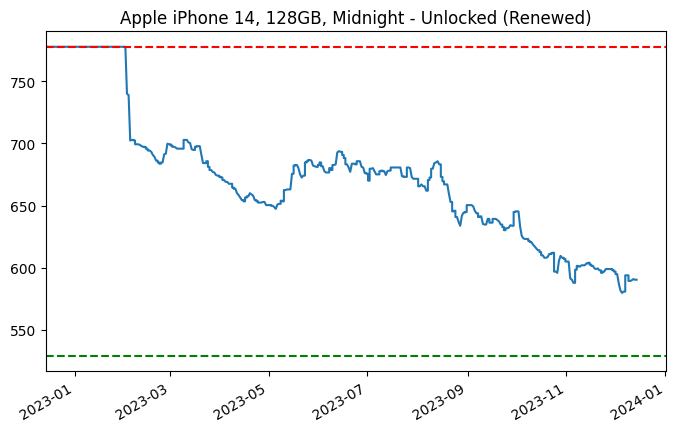

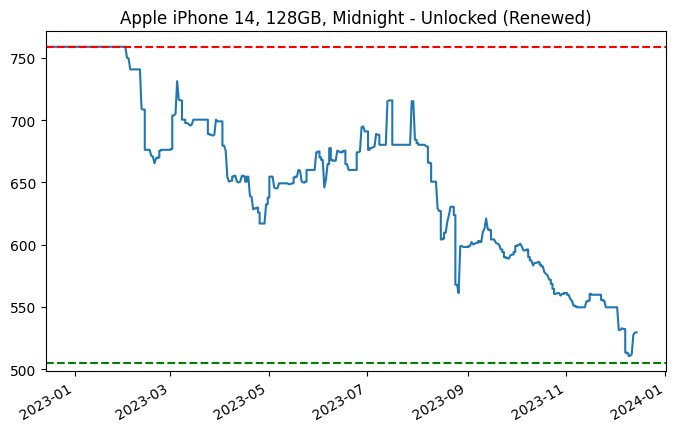

In [44]:
for p_type in ['amazon', 'new', 'used']:

    img = Image.open(f'images/{PRODUCT_ID}/{p_type}.png')
    data = np.array(img)

    check_passed = check_image(data)
    if not check_passed:
        continue

    data_r = (255*np.around(data/255, 0).reshape(data.shape)).astype('uint8') # reduce image to five colors
    data_c = crop_frame(data_r, colors)
    trace = find_trace(data_c, colors)
    final_trace = get_price_dates(trace, prices[p_type])
    final_trace.to_csv(f'data/{PRODUCT_ID}_{p_type}.csv')

    fig, ax = plt.subplots(figsize = (8, 5))
    final_trace.plot(ax = ax, title = title, xlim = [final_trace.index.min(), None])
    ax.axhline(prices[p_type]['max'], ls = '--', color = 'red')
    ax.axhline(prices[p_type]['min'], ls = '--', color = 'green')
    plt.savefig(f'images/{PRODUCT_ID}/{p_type}_rep.png')
    plt.show()